In [73]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
# from pybullet_envs.gym_pendulum_envs import InvertedPendulumSwingupBulletEnv
# from gym.envs.box2d import LunarLanderContinuous
from pybullet_envs.gym_locomotion_envs import HopperBulletEnv

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [74]:
class MDN(nn.Module):
    def __init__(self, num_inputs, num_outputs, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(num_inputs, n_hidden),
            nn.ReLU()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians * num_outputs)
        self.z_mu = nn.Linear(n_hidden, n_gaussians * num_outputs)  
    
        self.num_outputs = num_outputs
        self.num_gauss   = n_gaussians
        self.num_inputs  = num_inputs
    
    def sample(self, x, u):
        pi, sigma, mu = self.forward(x, u)
#         pi_picked = torch.multinomial(pi, 1)
        pi_picked = torch.argmax(pi, dim=1, keepdim=True)
        res = []
        for i, r in enumerate(pi_picked):
            res.append(
                torch.normal(mu[i, r], sigma[i, r])
            )
        
        return torch.cat(res)
    
    def logits(self, x,u, y):
        pi, sigma, mu = self.forward(x, u)
        y_expand = y.unsqueeze(1).expand_as(mu)

        log_pi = torch.log(pi)
        log_pdf = -torch.log(sigma).sum(2)-0.5*((y_expand - mu) * torch.reciprocal(sigma)).pow(2).sum(2)
        return torch.logsumexp(log_pdf + log_pi, dim=1, keepdim=True)
    
    def forward(self, x, u):
        z_h = self.z_h(torch.cat([x, u], dim=1))
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        sigma = torch.clamp(self.z_sigma(z_h), -20, 4).exp()
        
        mu = self.z_mu(z_h).view(-1, self.num_gauss, self.num_outputs)
        mu = mu + x.unsqueeze(1).expand_as(mu)
        return pi, sigma.view(-1, self.num_gauss, self.num_outputs), mu

In [117]:
data = {
    'states' : [],
    'actions' : [],
    'next_states' : []
}

In [118]:
env = HopperBulletEnv()

In [119]:

for k in range(10):
    state = env.reset()
    action = env.action_space.sample()*0.
    for t in range(200):
        action = env.action_space.sample()
        for _ in range(1):
            next_state, rew, done, _ = env.step(action)
        if done:
            break
        data['states'].append(state.copy())
        data['actions'].append(action.copy())
        data['next_states'].append(next_state.copy())

        state = next_state



In [120]:
states = torch.FloatTensor(np.stack(data['states']))
actions = torch.FloatTensor(np.stack(data['actions']))
next_states = torch.FloatTensor(np.stack(data['next_states']))

In [121]:
model = MDN(env.action_space.shape[0] + env.observation_space.shape[0], 
            env.observation_space.shape[0], 32, 3)

In [122]:
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-3)

900 -49.997169494628906


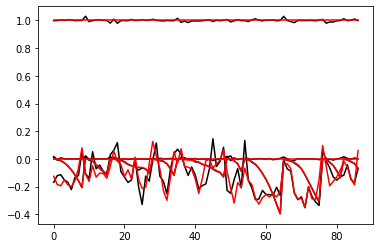

In [124]:
for i in range(1000):

    loss = -torch.mean(model.logits(states, actions, next_states))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        pred_next_states = model.sample(states, actions)
        clear_output(True)
        print(i, loss.item())
        plt.plot(pred_next_states.data.numpy()[:200,:4], 'k')
        plt.plot(next_states.data.numpy()[:200,:4], 'r')
        plt.pause(0.1)

In [115]:
# pred_next_states = model.sample(states[0].unsqueeze(0), actions[0].unsqueeze(0))
pred_next_states = model.sample(states, actions)

In [103]:
pred_next_states

tensor([[-1.4888e-03,  2.9851e-02,  1.0065e+00, -4.3906e-01,  1.3421e-03,
          1.2676e-01, -2.3971e-03, -1.3370e-01,  8.2486e-01, -2.5774e-01,
          8.8102e-01, -4.7609e-01, -5.4825e-01, -9.9394e-02,  1.3378e+00],
        [-9.5172e-03,  1.4118e-03,  9.8801e-01, -2.8120e-01,  1.0380e-02,
         -3.4970e-01,  3.2679e-03, -1.7274e-01,  1.1543e+00, -1.6312e-02,
          6.7229e-01, -1.0659e+00,  1.3101e-01,  2.2485e-01,  6.0525e-01],
        [-1.4103e-01, -4.0316e-03,  1.0005e+00,  1.4788e-01,  1.1399e-02,
         -7.5688e-01, -9.9045e-04, -7.4422e-01,  6.1474e-01, -1.6105e+00,
          6.0646e-01, -5.6085e-01,  4.6423e-01, -2.8533e-01,  2.4826e-01],
        [-2.6252e-02, -1.1930e-02,  9.8568e-01,  1.6505e-01,  7.3827e-03,
         -2.7307e-01, -1.1878e-02, -2.3568e-01,  6.4739e-01, -2.1376e+00,
          1.0058e+00,  3.5580e-01, -1.3731e-01,  2.7886e-01,  6.0332e-01],
        [-5.4500e-02,  5.7120e-04,  9.9917e-01, -1.8197e-01,  8.1235e-04,
         -2.3058e-02,  1.6395e-04,

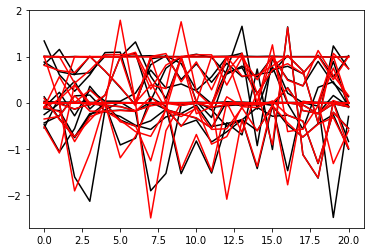

In [104]:
plt.plot(pred_next_states.data.numpy()[:200], 'k')
plt.plot(next_states.data.numpy()[:200], 'r')

In [105]:
pi, sigma, mu = model(states, actions)

In [106]:
torch.multinomial(pi, 1)

tensor([[2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [0],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [0]])

In [107]:
torch.argmax(pi, dim=1, keepdim=True)

tensor([[2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [0],
        [2],
        [2],
        [2]])

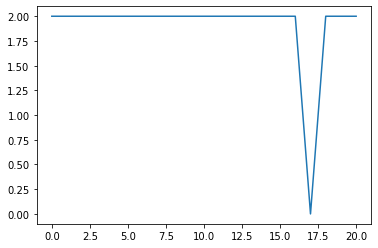

In [108]:
plt.plot(torch.argmax(pi, dim=1).data.numpy())

In [57]:
torch.argmax(pi, dim=1)

tensor([3, 3, 3, 3, 3, 3, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 4, 0, 3, 3, 4, 3,
        3, 3, 4, 4, 3, 4, 4, 3, 4, 0, 4, 4, 4, 4, 4, 0, 4, 3, 3, 0, 0, 4, 4, 3,
        4, 4, 3, 3, 3, 3, 3, 4, 3, 2, 3, 3, 3, 3, 3, 0, 3, 3, 0, 4, 4, 4, 4, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 4, 3, 3, 4,
        0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 3, 4, 4, 3, 3, 3, 4, 3, 3, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 3, 3, 0, 4, 3,
        4, 0, 3, 4, 4, 3, 3, 0, 3, 3, 3, 3, 3, 2, 4, 3, 3, 3, 0, 0, 0, 0, 3, 3,
        0, 4, 4, 3, 3, 4, 4, 4, 3, 4, 3, 3, 0, 4, 4, 4, 4, 3, 3, 4, 0, 3, 3, 4,
        3, 3, 3, 3, 3, 4, 4, 3, 3, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 3, 3, 4, 0, 0,
        0, 3, 0, 0, 0, 4, 3, 4, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2,
        3, 3, 2, 3, 3, 4, 4, 4, 2, 2, 2,